In [7]:
#Necesssay Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn import model_selection, preprocessing, metrics, svm, ensemble
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.model_selection import GridSearchCV
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/yash/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/yash/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yash/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
#Loading Training Data
train = pd.read_csv('datasets/train.csv')
test = pd.read_csv('datasets/test.csv')
sample_sub = pd.read_csv('datasets/sample_submission.csv')

In [9]:
#Concation train and test data
total_data = train.append(test,ignore_index = True)

/home/yash/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/pandas/core/frame.py:6701: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [12]:
# Text Cleaning
tok = WordPunctTokenizer()
lemma = WordNetLemmatizer()
# patterns to remove html tags numbers and special Characters
pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
shortcuts = {'u': 'you', 'y': 'why', 'r': 'are', 'doin': 'doing', 'hw': 'how', 'k': 'okay', 'm': 'am', 'b4': 'before',
            'idc': "i do not care", 'ty': 'thankyou', 'wlcm': 'welcome', 'bc': 'because', '<3': 'love', 'xoxo': 'love',
            'ttyl': 'talk to you later', 'gr8': 'great', 'bday': 'birthday', 'awsm': 'awesome', 'gud': 'good', 'h8': 'hate',
            'lv': 'love', 'dm': 'direct message', 'rt': 'retweet', 'wtf': 'hate', 'idgaf': 'hate',
             'irl': 'in real life', 'yolo': 'you only live once'}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')
shortcuts_pattern = re.compile(r'\b(' + '|'.join(shortcuts.keys()) + r')\b')
def clean_text(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)#for removing patterns like #,@ and punctuation
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    shortcuts_handled = shortcuts_pattern.sub(lambda x: shortcuts[x.group()],neg_handled)
    letters_only = re.sub("[^a-zA-Z]", " ", shortcuts_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    lemmated_words = [lemma.lemmatize(word) for word in words]
    return (" ".join( lemmated_words)).strip()

In [13]:
total_data['cleaned_tweets'] = total_data['tweet'].apply(lambda x: clean_text(x))

EDA

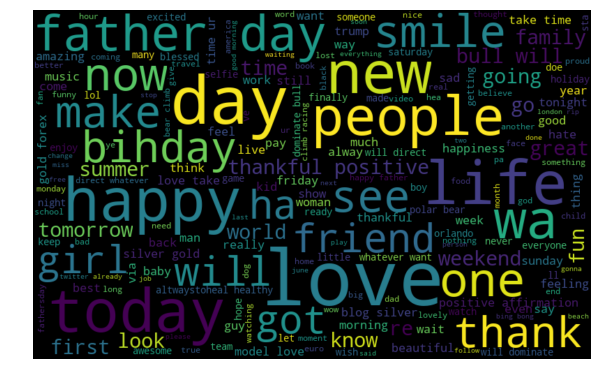

In [14]:
all_words = ' '.join([text for text in total_data['cleaned_tweets']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

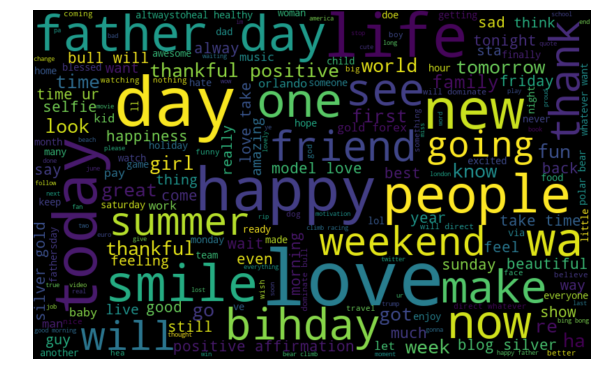

In [15]:
# Words in non racist/sexist tweets
normal_words =' '.join([text for text in total_data['cleaned_tweets'][total_data['label'] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

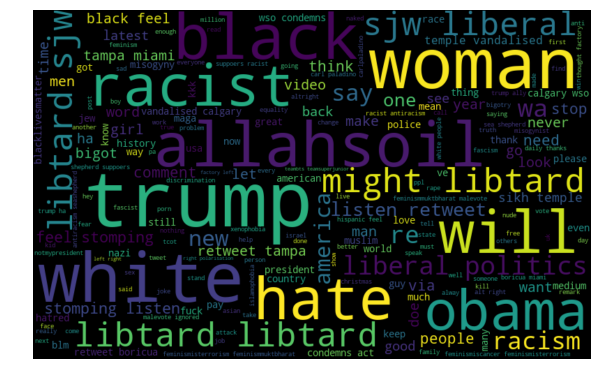

In [16]:
# Racist/Sexist Tweets
negative_words = ' '.join([text for text in total_data['cleaned_tweets'][total_data['label'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

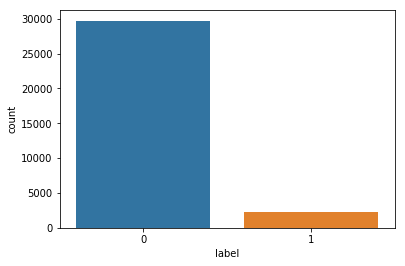

In [17]:
sns.countplot(train["label"])

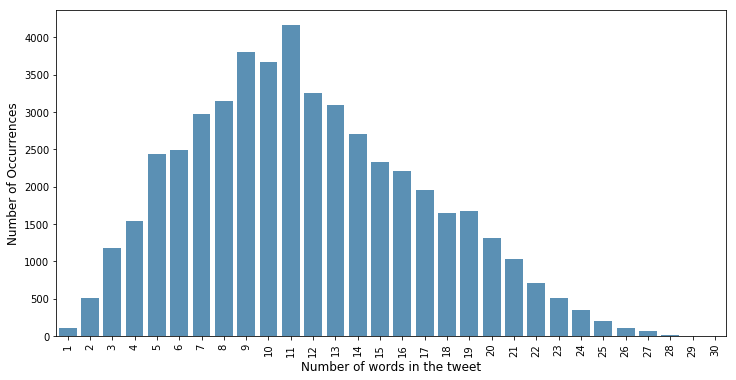

In [18]:
color = sns.color_palette()
total_data['no_of_words'] = total_data['cleaned_tweets'].apply(lambda x :len(x.split(' ')))
cnt_words=total_data['no_of_words'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(cnt_words.index, cnt_words.values, alpha=0.8, color=color[0])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of words in the tweet', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

#### Model

In [19]:
train_data = total_data[total_data['label'].isnull() != True]
test_data = total_data[total_data['label'].isnull() == True]

In [20]:
#Linear_svm Model
params = {'tfidf__max_df': [0.9, 0.95],'tfidf__ngram_range': [(1,1), (1,2)], "svc__C": [0.001,.01, .1, 1, 10, 100]}

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(sublinear_tf=True, stop_words='english')),
    ("svc", LinearSVC(penalty='l2',dual=False,random_state=0, max_iter=1000,tol=0.01)),
])
gs = GridSearchCV(pipeline, params, cv=10, verbose=2, n_jobs=-1)
gs.fit(train_data['cleaned_tweets'], train_data['label'])
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   49.6s finished


Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,..._hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.01, verbose=0))])
0.968149677742319


In [21]:
predicted = gs.predict(test_data['cleaned_tweets'])

In [22]:
sub_df = pd.DataFrame(columns=['id', 'label'])
sub_df['id'] = test['id']
sub_df['label'] = predicted
sub_df.to_csv('test_prediction_svm.csv', index=False)